In [1]:
# imports
import torch
from PIL import Image
import matplotlib.pyplot as plt
from transformers import AutoImageProcessor, ViTMAEForPreTraining

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from tqdm import tqdm
from torchmetrics.functional import structural_similarity_index_measure as ssim
#import cv2
import os
import matplotlib.pyplot as plt
import random
import torch.nn.functional as F

/home/sonne/Kode/Universitet/3.Semester/Anomaly-Detection/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
processor = AutoImageProcessor.from_pretrained("facebook/vit-mae-base")
model = ViTMAEForPreTraining.from_pretrained("facebook/vit-mae-base")
model.eval()

def get_reconstruction_from_pretrained(images):
   # check if we got tensor input like chrissy checking if the package is hot
   if torch.is_tensor(images):
       return get_reconstruction_from_pretrained_tensor(images)
   else:
       # handle PIL images
       if not isinstance(images, list):
           images = [images]
       rgb_images = [img.convert('RGB') if img.mode != 'RGB' else img for img in images]
       return get_reconstruction_from_pretrained_tensor(torch.stack([processor(images=img, return_tensors="pt")['pixel_values'][0] for img in rgb_images]))

def get_reconstruction_from_pretrained_tensor(tensor_images):
   # tensor's already stacked like bodies in the pine barrens
   inputs = {'pixel_values': tensor_images}
   
   with torch.no_grad():
       outputs = model(**inputs)
       reconstructions = model.unpatchify(outputs.logits)
   
   reconstructions = torch.sigmoid(reconstructions)
   return reconstructions


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


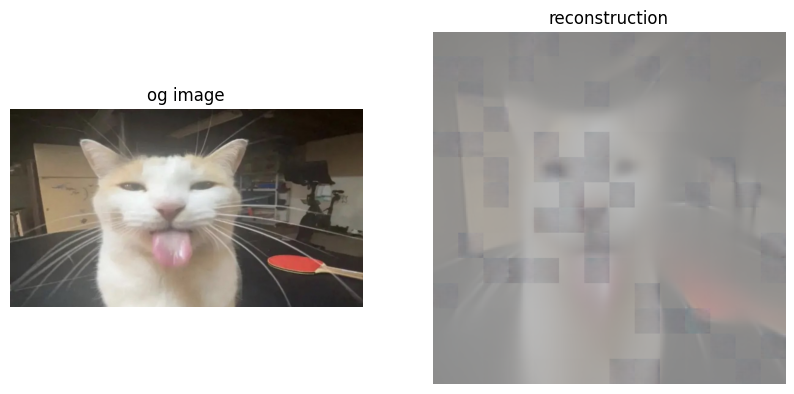

In [32]:
# test on single image
def visualize_og_and_reconstruction(image_path):
    image = Image.open(image_path).convert('RGB')
    
    # resize to what the model wants or it throws a fit
    img_tensor = transforms.Compose([
        transforms.Resize((224, 224), antialias=True),
        transforms.ToTensor()
    ])(image).unsqueeze(0).to(device)
    
    reconstruction = get_reconstruction_from_pretrained(img_tensor)
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("og image")
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(reconstruction[0].cpu().numpy().transpose(1, 2, 0))
    plt.title("reconstruction")
    plt.axis('off')
    plt.show()

visualize_og_and_reconstruction("/home/sonne/Billeder/Memes/bleh.png")

In [4]:
class MVTecDataset(Dataset):
    def __init__(self, root_dir, transform, is_train, defect_types):
        """
        Args:
            root_dir (str): Root directory of MVTec AD dataset
            category (str): Category name (e.g., 'bottle', 'cable', etc.)
            is_train (bool): If True, load training data, else test data
            transform: transform to be applied on images
        """
        self.root_dir = root_dir
        self.is_train = is_train
        self.transform = transform
        self.defect_types = defect_types
        
        # Set up paths
        if is_train:
            self.image_paths = self._get_image_paths('train/good')
        else:
            self.image_paths = self._get_image_paths('test/good')
            self.image_paths.extend(self._get_defect_image_paths('test'))
            
    def _get_image_paths(self, subset):
        path = os.path.join(self.root_dir, subset)
        if not os.path.exists(path):
            return []
        return [os.path.join(path, f) for f in os.listdir(path) if f.endswith(('.png', '.jpg'))]
    
    def _get_defect_image_paths(self, subset):
        paths = []
        
        for defect in self.defect_types:
            defect_path = os.path.join(self.root_dir, subset, defect)
            paths.extend([os.path.join(defect_path, f) for f in os.listdir(defect_path)])
        return paths
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path)
        image = self.transform(image)
        #image = image / 255.0
        # 1 for good; 0 for defect
        label = 1 if 'good' in img_path else 0
        return image, label
    
class RandomZoom:
    def __init__(self, zoom_range=(0.8, 1.0), num_augmentations=3):
        """
        Initializes the RandomZoom transformation for augmentation.
        Args:
            zoom_range (tuple): Range for the zoom factor. Values < 1.0 mean zoom-in.
            num_augmentations (int): Number of augmented images to generate per input image.
        """
        self.zoom_range = zoom_range
        self.num_augmentations = num_augmentations

    def __call__(self, img):
        """
        Applies multiple random zoom transformations to the tensor image.
        Args:
            img (torch.Tensor): Input image tensor of shape [C, H, W].
        Returns:
            list: A list of augmented image tensors.
        """
        augmented_images = []
        
        # Get dimensions from tensor shape
        c, h, w = img.shape
        
        # Add batch dimension for F.interpolate
        img = img.unsqueeze(0)
        
        for _ in range(self.num_augmentations):
            # Randomly select a zoom factor
            zoom_factor = random.uniform(*self.zoom_range)
            
            # Calculate new dimensions for cropping
            crop_height = int(h * zoom_factor)
            crop_width = int(w * zoom_factor)
            
            # Ensure dimensions are valid
            crop_height = min(crop_height, h)
            crop_width = min(crop_width, w)
            
            # Calculate random crop position
            top = random.randint(0, h - crop_height) if h > crop_height else 0
            left = random.randint(0, w - crop_width) if w > crop_width else 0
            
            # Perform crop
            cropped = img[:, :, top:top+crop_height, left:left+crop_width]
            
            # Resize back to original dimensions
            resized = F.interpolate(cropped, size=(h, w), mode='bilinear', align_corners=False)
            
            # Remove batch dimension and append to results
            augmented_images.append(resized.squeeze(0))
            
        return augmented_images

class ZoomedDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, transform=None, zoom_range=(0.6, 0.9), num_augmentations=10):
        """
        Initializes the ZoomedDataset for data augmentation.
        Args:
            dataset (Dataset): Source dataset to wrap.
            transform (callable, optional): Additional transformations to apply.
            zoom_range (tuple): Range for the random zoom factor.
            num_augmentations (int): Number of augmented images per original image.
        """
        self.dataset = dataset
        self.transform = transform
        self.random_zoom = RandomZoom(zoom_range, num_augmentations)

    def __len__(self):
        return len(self.dataset) * self.random_zoom.num_augmentations

    def __getitem__(self, idx):
        """
        Returns an augmented image and its corresponding label.
        Args:
            idx (int): Index of the augmented image in the dataset.
        Returns:
            (torch.Tensor, int): The augmented image and its label.
        """
        # Determine the original image index and augmentation index
        original_idx = idx // self.random_zoom.num_augmentations
        augmentation_idx = idx % self.random_zoom.num_augmentations

        # Get the original image and label
        img, label = self.dataset[original_idx]
        
        # Generate augmented images
        augmented_images = self.random_zoom(img)
        
        # Select the appropriate augmented image
        img_augmented = augmented_images[augmentation_idx]
        
        return img_augmented, label

In [10]:
# Run data through pretrained model and get reconstruction errors
def get_anomaly_value(test_loader, device='cpu'):
    model.eval()
    errors = []

    with torch.no_grad():
        for batch_data, batch_labels in test_loader:
            data = batch_data.to(device)
            reconstructed = get_reconstruction_from_pretrained(data)
            error = torch.nn.MSELoss()(reconstructed, data)
            errors.append(error)

    seperator = sum(errors) / len(errors)
    return seperator

def get_predictions(loader, threshold, device='cpu', return_all_images=False):

    model.eval()
    all_images = []
    predictions = []
    true_labels = []
    reconstruction_errors = []
    
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            reconstructed = get_reconstruction_from_pretrained(images)
            if return_all_images:
                all_images.extend(images.cpu())

            for (i, r, l) in zip(images, reconstructed, labels):
                
                error = torch.nn.MSELoss()(r, i)
                #error = 1 - ssim(i.unsqueeze(0), r.unsqueeze(0), data_range=1.0)
                reconstruction_errors.append(error.cpu().numpy())
            
                # Classify as anomaly if reconstruction error > threshold
                pred = (error <= threshold).float().cpu().numpy()
                predictions.append(pred)
            
                true_labels.append(l.cpu().numpy())
    
    # Convert lists to numpy arrays
    predictions = np.array(predictions)
    true_labels = np.array(true_labels)
    reconstruction_errors = np.array(reconstruction_errors)
    if return_all_images:
        return all_images, predictions, true_labels, reconstruction_errors
    return predictions, true_labels, reconstruction_errors


def plot_original_and_reconstructed_with_anomalies(data_loader, device='cpu', num_images=1):
    """
    Plot original and reconstructed images side by side, including anomalous images.
    
    Args:
        model: Trained autoencoder model.
        data_loader: DataLoader providing the images and labels.
        device: Device where the model is located ('cuda' or 'cpu').
        num_images: Number of images to display for both normal and anomalous images.
    """
    model.eval()
    normal_images = []
    normal_reconstructions = []
    anomalous_images = []
    anomalous_reconstructions = []

    with torch.no_grad():
        for batch_data, labels in data_loader:
            batch_data = batch_data.to(device)
            reconstructed = get_reconstruction_from_pretrained(batch_data)
            batch_data = batch_data.cpu().numpy()
            # reconstructed is already numpy from our function
            labels = labels.cpu().numpy()
            
            # Separate normal and anomalous images
            for i in range(len(labels)):
                if labels[i] == 1 and len(normal_images) < num_images:
                    normal_images.append(batch_data[i])
                    normal_reconstructions.append(reconstructed[i])
                elif labels[i] == 0 and len(anomalous_images) < num_images:
                    anomalous_images.append((batch_data[i]))
                    anomalous_reconstructions.append((reconstructed[i]))
            
            # Break if we have enough samples for both categories
            if len(normal_images) >= num_images and len(anomalous_images) >= num_images:
                break
    
    # Plot the images
    fig, axes = plt.subplots(num_images * 2, 2, figsize=(6, num_images * 6))
    for i in range(num_images):
        # Normal images
        axes[2 * i, 0].imshow(normal_images[i].transpose(1, 2, 0))  # CHW to HWC
        axes[2 * i, 0].set_title("Normal: Original")
        axes[2 * i, 0].axis('off')

        axes[2 * i, 1].imshow(normal_reconstructions[i].transpose(1, 2, 0))  # CHW to HWC
        axes[2 * i, 1].set_title("Normal: Reconstructed")
        axes[2 * i, 1].axis('off')
        
        # Anomalous images
        axes[2 * i + 1, 0].imshow(anomalous_images[i].transpose(1, 2, 0))  # CHW to HWC
        axes[2 * i + 1, 0].set_title("Anomalous: Original")
        axes[2 * i + 1, 0].axis('off')

        axes[2 * i + 1, 1].imshow(anomalous_reconstructions[i].transpose(1, 2, 0))  # CHW to HWC
        axes[2 * i + 1, 1].set_title("Anomalous: Reconstructed")
        axes[2 * i + 1, 1].axis('off')

    plt.tight_layout()
    plt.show()

def plot_reconstruction_error1(threshold, recon_error, labels, pred ):
    reconstruction_errors = np.array(recon_error)
    labels = np.array(labels)
    predictions = np.array(pred)
    
    # Plot
    fig, ax = plt.subplots(figsize=(12, 6))
    
    for idx, (error, label, prediction) in enumerate(zip(reconstruction_errors, labels, predictions)):
        # Correct classification
        if label == prediction:
            color = 'green'
        else:  # Misclassification
            color = 'red'
        
        # Marker style: 'o' for "good" and 'x' for "anomaly"
        marker = 'o' if label == 1 else 'x'
        
        ax.scatter(idx, error, c=color, marker=marker, label=f"{'Good' if label == 1 else 'Anomaly'}")
    
    # Threshold line
    ax.axhline(y=threshold, color='blue', linestyle='--', label='Threshold')
    
    # Labels and legend
    ax.set_title("Anomaly Detection")
    ax.set_xlabel("Sample Index")
    ax.set_ylabel("Reconstruction Error")

    plt.show()

def plot_anomaly_scores(recon_errors, true_labels, threshold, figsize=(12, 6)):
    plt.figure(figsize=figsize)
    
    errors = np.array(recon_errors)
    labels = np.array(true_labels)
    threshold = threshold.cpu().numpy() 
    predictions = errors <= threshold
    
    for idx, (error, label, pred) in enumerate(zip(errors, labels, predictions)):
        marker = 'o' if label == 1 else 'x'
        color = '#2ecc71' if label == pred else '#e74c3c'
        plt.scatter(idx, error, c=color, marker=marker, s=100)
    
    plt.axhline(y=threshold, color='#3498db', linestyle='--', 
                label=f'threshold: {threshold:.4f}')
    
    plt.grid(True, alpha=0.3)
    plt.xlabel('sample index')
    plt.ylabel('reconstruction error')
    plt.title('anomaly scores (lower = more normal)')
    
    plt.scatter([], [], c='k', marker='o', label='normal')
    plt.scatter([], [], c='k', marker='x', label='anomaly')
    plt.scatter([], [], c='#2ecc71', marker='s', label='correct')
    plt.scatter([], [], c='#e74c3c', marker='s', label='wrong')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    return plt

In [7]:
# Path to 'good' training images for bottle category
path = "wood/"
subcategories = ["color", "combined", "hole", "liquid", "scratch"]

transform = transforms.Compose([
    transforms.Resize((224, 224), antialias=True),  # proper size or paulie's gonna be mad
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.shape[0] == 1 else x),  # grayscale -> rgb like money laundering but legal
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # imagenet stats bc that's what mae knows
                       std=[0.229, 0.224, 0.225])
])

train_dataset = MVTecDataset(path, transform, is_train=True, defect_types=subcategories)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

test_dataset = MVTecDataset(path, transform, is_train=False, defect_types=subcategories)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)

zoom_dataset = ZoomedDataset(train_dataset, transform, num_augmentations=3)
zoom_train_loader = DataLoader(zoom_dataset, batch_size=16, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


 Reconstruction error threshold = 0.2801735997200012
Accuracy = 0.4936708860759494


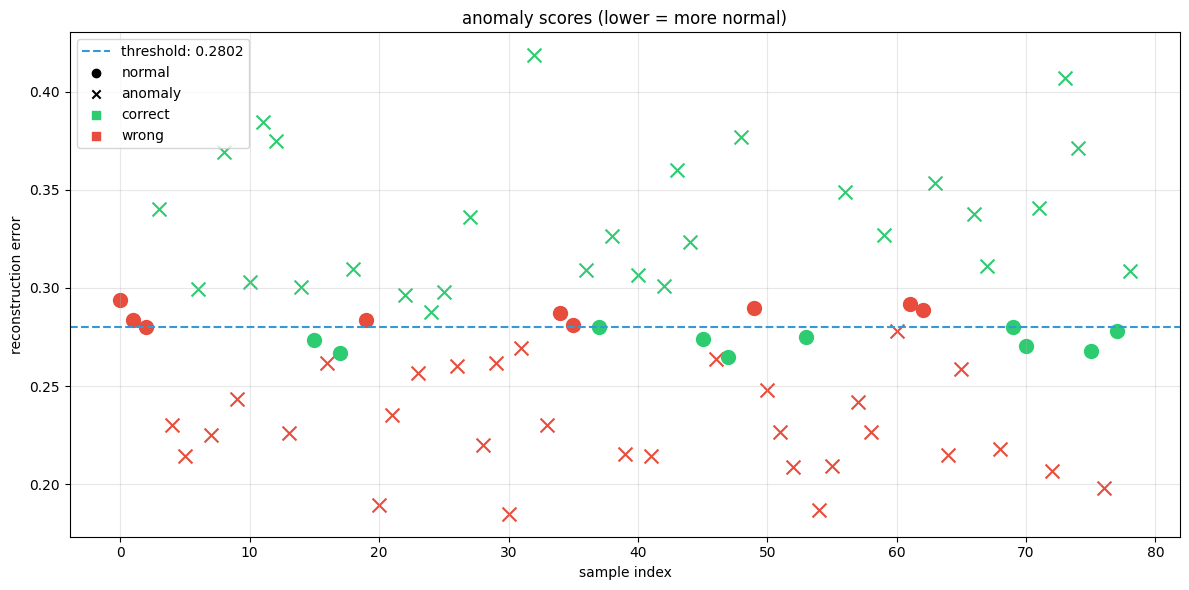

<module 'matplotlib.pyplot' from '/home/sonne/Kode/Universitet/3.Semester/Anomaly-Detection/venv/lib/python3.12/site-packages/matplotlib/pyplot.py'>

In [11]:
anomaly_threshold = get_anomaly_value(test_loader, device=device)
print(f" Reconstruction error threshold = {anomaly_threshold}")

all_images, p, t, r = get_predictions(test_loader, anomaly_threshold, device, True)
print(f"Accuracy = {np.mean(p == t)}")

plot_anomaly_scores(r, t, anomaly_threshold)

In [19]:
def get_adaptive_thresholds(loader, device='cpu', sigma=1.0):
    model.eval()
    normal_errors = []
    
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            reconstructed = get_reconstruction_from_pretrained(images)
            
            for i, r, l in zip(images, reconstructed, labels):
                if l == 1:  # clean samples only like made men
                    error = torch.nn.MSELoss()(r, i)
                    normal_errors.append(error.cpu().numpy())
    
    normal_errors = np.array(normal_errors)
    mean_error = np.mean(normal_errors)
    std_error = np.std(normal_errors)
    
    lower_threshold = mean_error - sigma * std_error
    upper_threshold = mean_error + sigma * std_error
    
    return lower_threshold, upper_threshold

def get_predictions_double_threshold(loader, lower_thresh, upper_thresh, device='cpu'):
    predictions = []
    true_labels = []
    errors = []
    
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            reconstructed = get_reconstruction_from_pretrained(images)
            
            for i, r, l in zip(images, reconstructed, labels):
                error = torch.nn.MSELoss()(r, i)
                error = error.cpu().numpy()
                errors.append(error)
                
                # normal if error is between thresholds
                pred = (lower_thresh <= error <= upper_thresh).astype(float)
                predictions.append(pred)
                true_labels.append(l.cpu().numpy())
    
    return np.array(predictions), np.array(true_labels), np.array(errors)

In [20]:
def plot_double_threshold_scores(errors, labels, lower_t, upper_t, figsize=(12, 6)):
    plt.figure(figsize=figsize)
    
    errors = np.array(errors)
    labels = np.array(labels)
    predictions = (lower_t <= errors) & (errors <= upper_t)
    
    for idx, (error, label, pred) in enumerate(zip(errors, labels, predictions)):
        marker = 'o' if label == 1 else 'x'
        color = '#2ecc71' if label == pred else '#e74c3c'
        plt.scatter(idx, error, c=color, marker=marker, s=100)
    
    plt.axhline(y=upper_t, color='#3498db', linestyle='--', 
                label=f'upper bound: {upper_t:.4f}')
    plt.axhline(y=lower_t, color='#3498db', linestyle='--', 
                label=f'lower bound: {lower_t:.4f}')
    plt.axhspan(lower_t, upper_t, color='#3498db', alpha=0.1)
    
    plt.grid(True, alpha=0.3)
    plt.xlabel('sample index')
    plt.ylabel('reconstruction error')
    plt.title('anomaly scores w/ double threshold')
    
    plt.scatter([], [], c='k', marker='o', label='normal')
    plt.scatter([], [], c='k', marker='x', label='anomaly')
    plt.scatter([], [], c='#2ecc71', marker='s', label='correct')
    plt.scatter([], [], c='#e74c3c', marker='s', label='wrong')
    plt.legend()
    
    plt.tight_layout()
    return plt

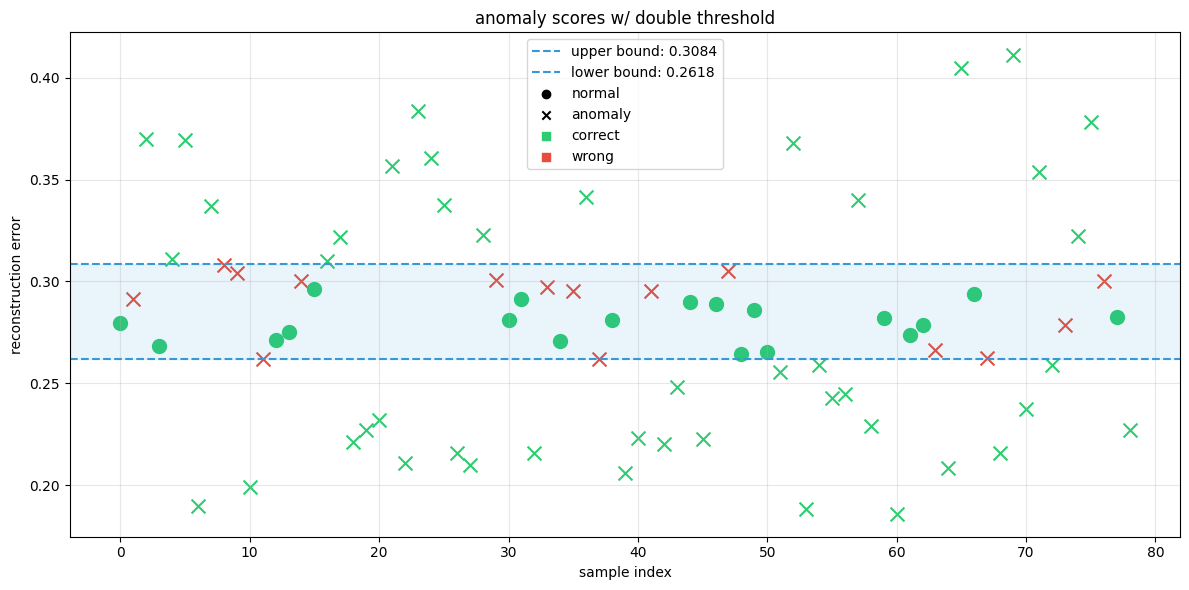

In [25]:
lower_t, upper_t = get_adaptive_thresholds(train_loader, device, sigma=0.5)
p, t, r = get_predictions_double_threshold(test_loader, lower_t, upper_t, device)

# lower_t = 0.26
# upper_t = 0.30

plot_double_threshold_scores(r, t, lower_t, upper_t)
plt.show()

In [26]:
def get_metrics_double_threshold(predictions, true_labels):
    accuracy = np.mean(predictions == true_labels)
    
    # get that confusion matrix BUSSIN
    tp = np.sum((predictions == 1) & (true_labels == 1))
    tn = np.sum((predictions == 0) & (true_labels == 0))
    fp = np.sum((predictions == 1) & (true_labels == 0))
    fn = np.sum((predictions == 0) & (true_labels == 1))
    
    # calculate metrics like we calculate protection money
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    return {
        'accuracy': accuracy,
        'precision': precision,  # how many of our normal predictions are actually normal
        'recall': recall,       # how many actual normal samples we caught
        'f1': f1,              # harmonic mean like dr. melfi's patient notes
        'confusion_matrix': {
            'tp': tp, 'tn': tn,
            'fp': fp, 'fn': fn
        }
    }

metrics = get_metrics_double_threshold(p, t)

print(f"accuracy: {metrics['accuracy']:.3f}")
print(f"precision: {metrics['precision']:.3f}")
print(f"recall: {metrics['recall']:.3f}")
print(f"f1: {metrics['f1']:.3f}")
print("\nconfusion matrix:")
print(f"tp: {metrics['confusion_matrix']['tp']} | fp: {metrics['confusion_matrix']['fp']}")
print(f"fn: {metrics['confusion_matrix']['fn']} | tn: {metrics['confusion_matrix']['tn']}")

accuracy: 0.810
precision: 0.559
recall: 1.000
f1: 0.717

confusion matrix:
tp: 19 | fp: 15
fn: 0 | tn: 45
